ライブラリのインポート

In [702]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import seaborn as sns
import zipfile
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

データの読み込み

In [703]:
df=pd.read_csv("googleplaystore.csv")
df.head(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up
6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up
7,Infinite Painter,ART_AND_DESIGN,4.1,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33M,"1,000,000+",Free,0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up
9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.7,121,3.1M,"10,000+",Free,0,Everyone,Art & Design;Creativity,"July 3, 2018",2.8,4.0.3 and up


前処理

In [704]:
#NaNを削除
print(f'NaNの数: {df.isnull().sum().sum()}')
df['Rating'] = df['Rating'].fillna(df['Rating'].median())
df.dropna(inplace=True)
print(f'NaNの数: {df.isnull().sum().sum()}')
print(f'データの数: {len(df)}')
#カテゴリカルデータ
df=pd.get_dummies(df,columns=['Category','Genres','Content Rating','Type'])
#日付を扱うためにに変換する
df['Last Updated']=pd.to_datetime(df['Last Updated'])
df['Last Updated']=df['Last Updated'].map(datetime.datetime.toordinal)
#扱わないデータを消去
df=df.drop(["App",'Current Ver','Android Ver'],axis=1)
#データを整形
df['Price']=[float(p[1:]) if '$' in p else float(p) for p in df['Price']]
df['Installs']=[int(ins.strip('+').replace(',','')) for ins in df['Installs']]
df['Reviews'] = df['Reviews'].astype(int)

NaNの数: 1487
NaNの数: 0
データの数: 10829


In [705]:
#この処理はhttps://www.kaggle.com/data13/machine-learning-model-to-predict-app-rating-94　を参考にした
k_indices = df['Size'].loc[df['Size'].str.contains('k')].index.tolist()
converter = pd.DataFrame(df.loc[k_indices, 'Size'].apply(lambda x: x.strip('k')).astype(float).apply(lambda x: x / 1024).apply(lambda x: round(x, 3)).astype(str))
df.loc[k_indices,'Size'] = converter
df['Size'] = df['Size'].apply(lambda x: x.strip('M'))
df[df['Size'] == 'Varies with device'] = 0
df['Size'] = df['Size'].astype(float)

In [706]:
#Xとyに分け, さらにtrainとtestを分離する
y=df['Rating']
X=df.drop(['Rating'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

主成分分析(PCA)

In [707]:
#PCA
from sklearn.decomposition import PCA
print(f'次元数:{len(df.columns)}')
n_components=10

pca=PCA(n_components=10)
pca.fit(X)
print(f'次元数(PCA):{n_components}')
X_pca=pca.transform(X)
X_train_pca,X_test_pca,y_train_pca,y_test_pca=train_test_split(X_pca,y,test_size=0.25,random_state=10)

次元数:166
次元数(PCA):10


モデルの評価関数

In [708]:
def model_valuation(y,y_pred):
  tmp={}
  tmp['RMSE']=round(sklearn.metrics.mean_squared_error(y,y_pred),4)
  tmp['MAE']=round(sklearn.metrics.mean_absolute_error(y,y_pred),4)
  tmp['R^2']=round(sklearn.metrics.r2_score(y,y_pred),4)

  return tmp

線形回帰

In [709]:
#PCAなし
lr=LinearRegression()
trainscore={}
testscore={}
linear_models=[lr,Ridge(),Lasso()]
for model in linear_models:
  model.fit(X_train,y_train)
  y_pred=model.predict(X_train)
  y_pred_test=model.predict(X_test)
  trainscore[model.__class__.__name__]=model_valuation(y_train,y_pred)
  testscore[model.__class__.__name__]=model_valuation(y_test,y_pred_test)
print("trainscore : ")
for i,j in trainscore.items():
  print(i,j)
print("testscore : ")
for i,j in testscore.items():
  print(i,j)

trainscore : 
LinearRegression {'RMSE': 0.1975, 'MAE': 0.2757, 'R^2': 0.9219}
Ridge {'RMSE': 0.2001, 'MAE': 0.2789, 'R^2': 0.9208}
Lasso {'RMSE': 0.2093, 'MAE': 0.2851, 'R^2': 0.9172}
testscore : 
LinearRegression {'RMSE': 0.2185, 'MAE': 0.2766, 'R^2': 0.9143}
Ridge {'RMSE': 0.2147, 'MAE': 0.2787, 'R^2': 0.9158}
Lasso {'RMSE': 0.2198, 'MAE': 0.2819, 'R^2': 0.9138}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.3281e-20): result may not be accurate.
  overwrite_a=True).T


In [710]:
#PCAあり
lr=LinearRegression()
LR=LogisticRegression()
trainscore={}
testscore={}
linear_models=[lr,Ridge(),Lasso()]
for model in linear_models:
  model.fit(X_train_pca,y_train_pca)
  y_pred=model.predict(X_train_pca)
  y_pred_test=model.predict(X_test_pca)
  trainscore[model.__class__.__name__]=model_valuation(y_train_pca,y_pred)
  testscore[model.__class__.__name__]=model_valuation(y_test_pca,y_pred_test)
print("trainscore : ")
for i,j in trainscore.items():
  print(i,j)
print("testscore : ")
for i,j in testscore.items():
  print(i,j)

trainscore : 
LinearRegression {'RMSE': 0.2064, 'MAE': 0.2834, 'R^2': 0.9184}
Ridge {'RMSE': 0.2064, 'MAE': 0.2834, 'R^2': 0.9184}
Lasso {'RMSE': 0.2093, 'MAE': 0.2851, 'R^2': 0.9172}
testscore : 
LinearRegression {'RMSE': 0.2174, 'MAE': 0.28, 'R^2': 0.9148}
Ridge {'RMSE': 0.2174, 'MAE': 0.28, 'R^2': 0.9148}
Lasso {'RMSE': 0.2198, 'MAE': 0.2819, 'R^2': 0.9138}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.18789e-17): result may not be accurate.
  overwrite_a=True).T


k-NN

In [713]:
#pcaなし

model = KNeighborsRegressor(n_neighbors=20)
model.fit(X_train, y_train)
train_pred=model.predict(X_train)
test_pred=model.predict(X_test)
print('train')
print(model_valuation(y_train,train_pred))
print('test')
print(model_valuation(y_test,test_pred))

train
{'RMSE': 0.1753, 'MAE': 0.2607, 'R^2': 0.9307}
test
{'RMSE': 0.2032, 'MAE': 0.2678, 'R^2': 0.9204}


In [714]:
#pcaあり
model = KNeighborsRegressor(n_neighbors=20)
model.fit(X_train_pca, y_train_pca)
train_pred=model.predict(X_train_pca)
test_pred=model.predict(X_test_pca)
print('train')
print(model_valuation(y_train_pca,train_pred))
print('test')
print(model_valuation(y_test_pca,test_pred))

train
{'RMSE': 0.1752, 'MAE': 0.2607, 'R^2': 0.9307}
test
{'RMSE': 0.2032, 'MAE': 0.2679, 'R^2': 0.9203}


In [715]:
%matplotlib inline
step=2 #レポートでは1
n_neighbors = np.arange(20, 50, step)
scores = []
scores_pca=[]
for n in n_neighbors:
    model.set_params(n_neighbors=n)
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    dic=model_valuation(y_test,y_pred)
    scores.append(dic['RMSE'])
for n in n_neighbors:
    model.set_params(n_neighbors=n)
    model.fit(X_train_pca, y_train_pca)
    y_pred_pca=model.predict(X_test_pca)
    dic=model_valuation(y_test_pca,y_pred_pca)
    scores_pca.append(dic['RMSE'])


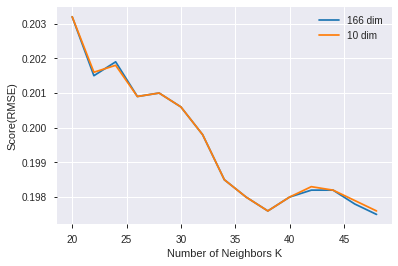

In [716]:
fig,ax=plt.subplots()

ax.set_xlabel("Number of Neighbors K")
ax.set_ylabel("Score(RMSE)")
ax.plot(n_neighbors, scores,label='166 dim')
ax.grid(True)
ax.plot(n_neighbors,scores_pca,label='10 dim')
ax.legend()
plt.show()



In [717]:
Kmodel=KNeighborsRegressor(n_neighbors=38)
Kmodel.fit(X_train_pca,y_train_pca)
pred=Kmodel.predict(X_test_pca)
for i in range(600):
  if 0<list(y_test)[i]<2:
    print(f'予測値:{pred[i]},実際の値:{list(y_test)[i]}')

予測値:4.423684210526316,実際の値:1.0
予測値:4.15,実際の値:1.7
予測値:4.234210526315789,実際の値:1.4


ランダムフォレスト+グリッドサーチ

In [718]:
#時間かかります
from sklearn.model_selection import RandomizedSearchCV

paramG = {'n_estimators':[197],'max_depth':[29,30,31]}
RFC_grid = GridSearchCV(estimator=RandomForestRegressor(random_state=0), param_grid=paramG,
                        scoring='r2', cv=3)
RFC_grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=

In [722]:
print('ランダムサーチ・ランダムフォレストモデルにおける n_estimators  :  %d'  %RFC_grid.best_estimator_.n_estimators)

print('ランダムサーチ・ランダムフォレストモデルにおける max_depth  :  %d'  %RFC_grid.best_estimator_.max_depth)
print('グリッドサーチ・ランダムフォレストモデルによる予測値   :  %.3f'  %r2_score(y_test, RFC_grid.predict(X_test)))
pred_rf1=RFC_grid.predict(X_test)
print(model_valuation(y_test,pred_rf1))


ランダムサーチ・ランダムフォレストモデルにおける n_estimators  :  197
ランダムサーチ・ランダムフォレストモデルにおける max_depth  :  31
グリッドサーチ・ランダムフォレストモデルによる予測値   :  0.927
{'RMSE': 0.1867, 'MAE': 0.2425, 'R^2': 0.9268}


In [683]:
#時間かかります

paramG = {'n_estimators':[197],'max_depth':[28,29,30,31,32]}
RFC_grid = GridSearchCV(estimator=RandomForestRegressor(random_state=0), param_grid=paramG,
                        scoring='r2', cv=3)
RFC_grid.fit(X_train_pca,y_train_pca)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=

In [684]:
print('ランダムサーチ・ランダムフォレストモデルにおける n_estimators  :  %d'  %RFC_grid.best_estimator_.n_estimators)

print('ランダムサーチ・ランダムフォレストモデルにおける max_depth  :  %d'  %RFC_grid.best_estimator_.max_depth)
print('グリッドサーチ・ランダムフォレストモデルによる予測値   :  %.3f'  %r2_score(y_test_pca, RFC_grid.predict(X_test_pca)))
pred=RFC_grid.predict(X_test_pca)
print(model_valuation(y_test_pca,pred))
for i in range(600):
  if 0<list(y_test_pca)[i]<2:
    print(f'予測値:{pred[i]},実際の値:{list(y_test_pca)[i]}')

ランダムサーチ・ランダムフォレストモデルにおける n_estimators  :  197
ランダムサーチ・ランダムフォレストモデルにおける max_depth  :  31
グリッドサーチ・ランダムフォレストモデルによる予測値   :  0.929
{'RMSE': 0.1807, 'MAE': 0.2481, 'R^2': 0.9291}
予測値:4.18840063641184,実際の値:1.0
予測値:3.57723545490043,実際の値:1.7
予測値:4.220812182741112,実際の値:1.4


{'Last Updated': 0.5569990947457093, 'Size': 0.39142800591390126, 'Reviews': 0.01850618139500673, 'Installs': 0.007964899590822944, 'Price': 0.001146805512594653, 'Genres_Entertainment': 0.0009569104223115668, 'Genres_Education': 0.0007959155893133172, 'Category_FAMILY': 0.0007042075999752105, 'Genres_Tools': 0.0006623489294660256, 'Category_LIFESTYLE': 0.000655158722048197, 'Category_TOOLS': 0.00065311465564046, 'Content Rating_Everyone': 0.0006319939695996311, 'Genres_Lifestyle': 0.0006268943569694668, 'Genres_Medical': 0.0005182410305440073, 'Category_MEDICAL': 0.0005175023524868368, 'Content Rating_Mature 17+': 0.0005011689737157804, 'Category_HEALTH_AND_FITNESS': 0.0004984074588018193, 'Genres_Health & Fitness': 0.0004747893064212724, 'Category_FINANCE': 0.00047345511679122644, 'Content Rating_Teen': 0.00045674071109146633, 'Genres_Finance': 0.00045071502472553214, 'Category_DATING': 0.0004302691724306651, 'Genres_Dating': 0.00041860645416260626, 'Genres_Photography': 0.0003985601

<BarContainer object of 20 artists>

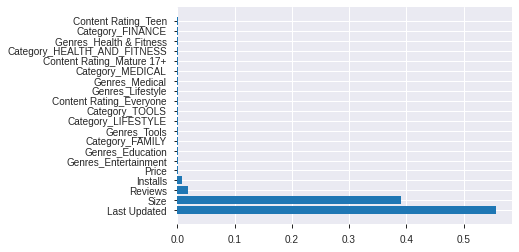

In [629]:
max_plt=20
model=RandomForestRegressor(n_estimators=197,max_depth=31)
model.fit(X_train,y_train)
d=np.arange(max_plt)
FeatureDict={}
for i in range(len(X_train.columns)):
  FeatureDict[X_train.columns[i]]=model.feature_importances_[i]
FeatureDict = dict(sorted(FeatureDict.items(), key=lambda x:x[1],reverse=True))
print(FeatureDict)
y=list(FeatureDict.values())
z=list(FeatureDict.keys())
plt.yticks(d,z[:max_plt])
plt.barh(d,y[:max_plt])

lightGBM+グリッドサーチ

In [685]:
#pcaなし
import lightgbm
paramG={'max_depth':[14,16,18,20,22,24],'n_estimators':[40,45,50,55,60]}
gbm=lightgbm.LGBMRegressor()
RFC_grid=GridSearchCV(estimator=gbm,param_grid=paramG, scoring='r2',cv=3)
RFC_grid.fit(X_train,y_train)
ypred2=model.predict(X_test)

In [686]:
print('グリッドサーチ·lightGBMにおける n_estimators  :  %d'  %RFC_grid.best_estimator_.n_estimators)

print('グリッドサーチ·lightGBMにおける max_depth  :  %d'  %RFC_grid.best_estimator_.max_depth)
print('グリッドサーチ・lightGBMによる予測値   :  %.3f'  %r2_score(y_test, RFC_grid.predict(X_test)))
pred_gbm=RFC_grid.predict(X_test)
print(model_valuation(y_test,pred_gbm))
for i in range(600):
  if 0<list(y_test)[i]<2:
    print(f'予測値:{pred_gbm[i]},実際の値:{list(y_test)[i]}')

グリッドサーチ·lightGBMにおける n_estimators  :  50
グリッドサーチ·lightGBMにおける max_depth  :  14
グリッドサーチ・lightGBMによる予測値   :  0.927
{'RMSE': 0.1875, 'MAE': 0.2568, 'R^2': 0.9265}
予測値:4.31949995513207,実際の値:1.0
予測値:3.810354807901916,実際の値:1.7
予測値:4.201470426941993,実際の値:1.4


{'Reviews': 335, 'Size': 269, 'Last Updated': 255, 'Installs': 181, 'Price': 41, 'Category_TOOLS': 31, 'Category_HEALTH_AND_FITNESS': 27, 'Genres_Education': 25, 'Category_LIFESTYLE': 21, 'Category_DATING': 20, 'Category_PERSONALIZATION': 16, 'Category_MEDICAL': 15, 'Category_VIDEO_PLAYERS': 15, 'Category_FINANCE': 14, 'Category_MAPS_AND_NAVIGATION': 13, 'Category_BOOKS_AND_REFERENCE': 12, 'Category_PHOTOGRAPHY': 12, 'Genres_Entertainment': 12, 'Category_PARENTING': 11, 'Category_ART_AND_DESIGN': 10, 'Category_COMMUNICATION': 10, 'Category_TRAVEL_AND_LOCAL': 10, 'Genres_Casual': 10, 'Content Rating_Everyone': 10, 'Category_LIBRARIES_AND_DEMO': 9, 'Category_EVENTS': 8, 'Category_PRODUCTIVITY': 8, 'Genres_Educational': 8, 'Content Rating_Mature 17+': 8, 'Category_FAMILY': 7, 'Genres_Racing': 7, 'Content Rating_Teen': 7, 'Category_BEAUTY': 6, 'Category_BUSINESS': 6, 'Category_EDUCATION': 6, 'Category_GAME': 6, 'Genres_Education;Education': 6, 'Genres_Simulation': 6, 'Category_AUTO_AND_VEH

<BarContainer object of 20 artists>

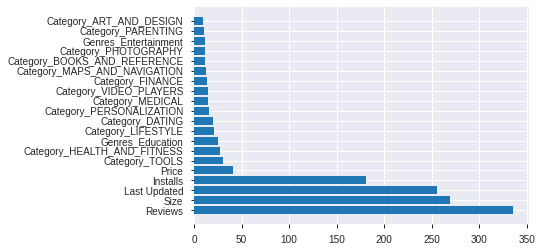

In [681]:
max_plt=20
model=lightgbm.LGBMRegressor(n_estimators=50,max_depth=14)
model.fit(X_train,y_train)
d=np.arange(max_plt)
FeatureDict={}
for i in range(len(X_train.columns)):
  FeatureDict[X_train.columns[i]]=model.feature_importances_[i]
FeatureDict = dict(sorted(FeatureDict.items(), key=lambda x:x[1],reverse=True))
print(FeatureDict)
y=list(FeatureDict.values())
z=list(FeatureDict.keys())
plt.yticks(d,z[:max_plt])
plt.barh(d,y[:max_plt])

In [677]:
#pcaあり
paramG={'max_depth':[14,16,18,20,22,24],'n_estimators':[40,45,50,55,60]}
gbm=lightgbm.LGBMRegressor()
RFC_grid=GridSearchCV(estimator=gbm,param_grid=paramG, scoring='r2',cv=3)
RFC_grid.fit(X_train_pca,y_train_pca)
ypred2=model.predict(X_test)

In [678]:
print('グリッドサーチ·lightGBMにおける n_estimators  :  %d'  %RFC_grid.best_estimator_.n_estimators)

print('グリッドサーチ·lightGBMにおける max_depth  :  %d'  %RFC_grid.best_estimator_.max_depth)
print('グリッドサーチ・lightGBMによる予測値   :  %.3f'  %r2_score(y_test, RFC_grid.predict(X_test_pca)))
pred=RFC_grid.predict(X_test_pca)
print(model_valuation(y_test_pca,pred))
for i in range(600):
  if 0<list(y_test)[i]<2:
    print(f'予測値:{pred[i]},実際の値:{list(y_test_pca)[i]}')

グリッドサーチ·lightGBMにおける n_estimators  :  50
グリッドサーチ·lightGBMにおける max_depth  :  16
グリッドサーチ・lightGBMによる予測値   :  0.926
{'RMSE': 0.1878, 'MAE': 0.26, 'R^2': 0.9264}
予測値:4.334249610342809,実際の値:1.0
予測値:3.6996459956394334,実際の値:1.7
予測値:4.309053787346207,実際の値:1.4


In [701]:
#ランダムフォレストとlightgbmの比較
for i in range(len(y_test_pca)):
  if 4.5<list(y_test_pca)[i]<5 and pred[i]<4:
    print(f'実際の値:{list(y_test_pca)[i]}')
    print(f'ランダムフォレスト:{pred[i]}')
    print(f'    \tlightGBM:{pred_gbm[i]}')
    print('\n')

実際の値:4.7
ランダムフォレスト:3.8825296108291014
    	lightGBM:3.9389449963336762


実際の値:4.6
ランダムフォレスト:3.6324873096446684
    	lightGBM:4.199489969059803


実際の値:4.9
ランダムフォレスト:3.9701957940536574
    	lightGBM:3.9675710083366775


実際の値:4.6
ランダムフォレスト:3.946700507614216
    	lightGBM:4.046382463903064


実際の値:4.6
ランダムフォレスト:3.8147208121827365
    	lightGBM:3.925505761338243


実際の値:4.6
ランダムフォレスト:3.88172588832488
    	lightGBM:4.057183793210185


実際の値:4.6
ランダムフォレスト:3.917512690355332
    	lightGBM:4.064669101589723


実際の値:4.8
ランダムフォレスト:3.898477157360401
    	lightGBM:4.213738286847616


実際の値:4.7
ランダムフォレスト:3.989847715736039
    	lightGBM:4.321834741405415


実際の値:4.6
ランダムフォレスト:3.7146192893401
    	lightGBM:4.073288254182798


実際の値:4.7
ランダムフォレスト:3.948984771573601
    	lightGBM:4.090157710545806


実際の値:4.7
ランダムフォレスト:3.9883248730964462
    	lightGBM:3.98126474260558


実際の値:4.6
ランダムフォレスト:3.8492385786802035
    	lightGBM:4.16388512126433


実際の値:4.6
ランダムフォレスト:3.8879406788095934
    	lightGBM:4.042513996723394


実際